In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
from pprint import pprint

import pickle

%matplotlib inline

## 1. Load data

In [2]:
PATH_TO_XDATA = 'data/h/XDATA.TXT'
PATH_TO_YDATA = 'data/h/YDATA.TXT'

In [11]:
dateparser = lambda x: pd.datetime.strptime(x, '%Y%m%d')
sumparser = lambda x: float(x) if x[-1] != '-' else float(x[:-1])

xdata = pd.read_csv(PATH_TO_XDATA, header=None, names=['DAT', 'SUM', 'ACCNT', 'MATNR','V5'],
                    parse_dates=['DAT'], dtype = {'SUM': float, 'ACCNT': str},
                    date_parser=dateparser, thousands=',', decimal='.')

xdata.drop(['MATNR','V5'], axis=1, inplace=True)
xdata.head()

,DAT,SUM,ACCNT
0,2017-02-28,5055.68,3802025999
1,2017-02-28,49913.44,3802025999
2,2017-02-28,11060.68,3802025999
3,2017-02-28,3361.01,3802025999
4,2017-02-28,344154.52,3802025999


In [13]:
ydata = pd.read_csv(PATH_TO_YDATA, header=None, names=['DAT', 'SUM', 'ACCNT', 'V4','V5'],
                    parse_dates=['DAT'], dtype = {'ACCNT': str}, converters = {'SUM': sumparser},
                    date_parser=dateparser, thousands=',', decimal='.')

ydata.drop(['ACCNT','V4', 'V5'], axis=1, inplace=True)
ydata.head()

,DAT,SUM
0,2015-06-04,19000000.0
1,2015-04-28,19000000.0
2,2016-05-10,19000000.0
3,2015-05-19,19000000.0
4,2016-04-21,19000000.0


## 2. Data preparation

### 2.1 YDATA

In [14]:
y_byday = ydata.groupby(by=['DAT']).sum().reset_index()
y_byday.head()

,DAT,SUM
0,2014-01-09,25653684.72
1,2014-01-10,30638612.57
2,2014-01-13,23861993.56
3,2014-01-14,74091230.99
4,2014-01-15,39481103.71


Split date into year/month/day:

In [18]:
y_byday['DAY'] = [date.day for date in y_byday.DAT]
y_byday['MONTH'] = [date.month for date in y_byday.DAT]
y_byday['YEAR'] = [date.year for date in y_byday.DAT]
y_byday.drop(['DAT'], axis=1, inplace=True)
y_byday = y_byday[['DAY','MONTH','YEAR', 'SUM']] 
y_byday.head()

,DAY,MONTH,YEAR,SUM
0,9,1,2014,25653684.72
1,10,1,2014,30638612.57
2,13,1,2014,23861993.56
3,14,1,2014,74091230.99
4,15,1,2014,39481103.71


In [19]:
y_bymonth = y_byday.groupby(by=['YEAR','MONTH']).sum().reset_index()
y_bymonth.drop(['DAY'], axis=1, inplace=True)

#### <font color="black"> Sum for grouped by YEAR:</font>

In [21]:
y_byyear = y_byday.groupby(by=['YEAR']).sum().reset_index()
y_byyear.drop(['DAY','MONTH'], axis=1, inplace=True)
y_byyear

,YEAR,SUM
0,2014,2.194844e+10
1,2015,3.032355e+10
2,2016,4.284977e+10
3,2017,8.683614e+09


***

## За Горячий прокат за 2016 - <font color="red">42.8 млрд</font>

## За Слябы за 2016 - <font color="red">XXX млрд</font>

***

#### Drop 3-th month of 2017 year, cause in XDATA we have only data from 2014-01 -> 2017-02

In [23]:
y_bymonth.drop(y_bymonth[(y_bymonth.YEAR == 2017) & (y_bymonth.MONTH == 3)].index, axis=0, inplace=True)

In [24]:
y_bymonth.shape

(38, 3)

### 2.2 XDATA

In [25]:
xdata.head()

,DAT,SUM,ACCNT
0,2017-02-28,5055.68,3802025999
1,2017-02-28,49913.44,3802025999
2,2017-02-28,11060.68,3802025999
3,2017-02-28,3361.01,3802025999
4,2017-02-28,344154.52,3802025999


In [26]:
x_byday = xdata.groupby(by=['DAT', 'ACCNT']).sum().reset_index()
x_byday.head()

,DAT,ACCNT,SUM
0,2014-01-31,3802025063,1.441403e+06
1,2014-01-31,3802025999,5.297051e+07
2,2014-02-28,3802025063,1.153347e+06
3,2014-02-28,3802025999,1.297696e+08
4,2014-03-31,3802025063,1.713427e+06


In [27]:
x_accnts = np.unique(x_byday.ACCNT)
print(x_accnts)

['3802025063' '3802025066' '3802025997' '3802025998' '3802025999']


In [28]:
print('Unique dates:', np.unique(x_byday.DAT))
print('\nNumber of dates:', len(np.unique(x_byday.DAT)))

Unique dates: ['2014-01-31T00:00:00.000000000' '2014-02-28T00:00:00.000000000'
 '2014-03-31T00:00:00.000000000' '2014-04-30T00:00:00.000000000'
 '2014-05-31T00:00:00.000000000' '2014-06-30T00:00:00.000000000'
 '2014-07-31T00:00:00.000000000' '2014-08-31T00:00:00.000000000'
 '2014-09-30T00:00:00.000000000' '2014-10-31T00:00:00.000000000'
 '2014-11-30T00:00:00.000000000' '2014-12-31T00:00:00.000000000'
 '2015-01-31T00:00:00.000000000' '2015-02-28T00:00:00.000000000'
 '2015-03-31T00:00:00.000000000' '2015-04-30T00:00:00.000000000'
 '2015-05-31T00:00:00.000000000' '2015-06-30T00:00:00.000000000'
 '2015-07-31T00:00:00.000000000' '2015-08-31T00:00:00.000000000'
 '2015-09-30T00:00:00.000000000' '2015-10-31T00:00:00.000000000'
 '2015-11-30T00:00:00.000000000' '2015-12-31T00:00:00.000000000'
 '2016-01-31T00:00:00.000000000' '2016-02-29T00:00:00.000000000'
 '2016-03-31T00:00:00.000000000' '2016-04-30T00:00:00.000000000'
 '2016-05-31T00:00:00.000000000' '2016-06-30T00:00:00.000000000'
 '2016-07-3

In [29]:
print('Data size:\t', x_byday.shape)

Data size:	 (113, 3)


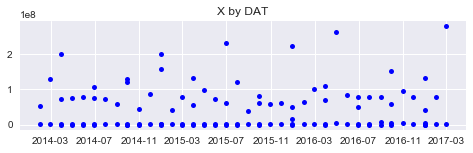

In [30]:
x = x_byday.DAT.copy()
y = x_byday.SUM.copy()
plt.figure(figsize=(8,2))
plt.plot(x,y, 'b.', ms=10)
plt.title('X by DAT')
plt.grid
plt.show()

Split date into year_month/day:

In [32]:
x_bymonth = x_byday.copy()
x_bymonth['MONTH'] = [date.month for date in x_bymonth.DAT]
x_bymonth['YEAR'] = [date.year for date in x_bymonth.DAT]
x_bymonth.drop(['DAT'],axis=1, inplace=True)
x_bymonth = x_bymonth[['MONTH','YEAR', 'SUM','ACCNT']] 

In [33]:
x_bymonth.shape

(113, 4)

#### Resize our XDATA:

In [36]:
last_year = np.unique(y_bymonth.YEAR)[-1]
last_month = np.unique(y_bymonth.MONTH[y_bymonth.YEAR == last_year])[-1]

first_year = np.unique(y_bymonth.YEAR)[0]
first_month = np.unique(y_bymonth.MONTH[y_bymonth.YEAR == last_year])[0]

N_MONTHS = (last_year-first_year) * 12 + last_month - first_month + 1

N_ACCNTS = len(x_accnts)

In [37]:
assert N_MONTHS == 38

In [38]:
X = pd.DataFrame(data=np.zeros((N_MONTHS, N_ACCNTS)), columns=np.arange(N_ACCNTS), index=np.arange(N_MONTHS))
for accnt,i in zip(x_accnts, np.arange(N_ACCNTS)):
    for month, year in zip(x_bymonth[x_bymonth.ACCNT == accnt].MONTH, x_bymonth[x_bymonth.ACCNT == accnt].YEAR):
        X[i].iloc[(month-1) + 12*(year-2014)] = x_bymonth[(x_bymonth.ACCNT == accnt) & (x_bymonth.MONTH == month) & (x_bymonth.YEAR == year)].SUM.values[0]

In [44]:
X.head()

,0,1,2,3,4
0,1441402.73,0.0,0.00,0.00,5.297051e+07
1,1153347.45,0.0,0.00,0.00,1.297696e+08
2,1713426.88,0.0,424897.43,73947829.48,1.997461e+08
3,2146402.71,0.0,0.00,1983.04,7.473753e+07
4,2675516.73,128120.1,0.00,0.00,7.743071e+07


In [45]:
X = X.copy().values

In [46]:
y = np.zeros((N_MONTHS,))
for month, year in zip(y_bymonth.MONTH, y_bymonth.YEAR):
    y[(month-1) + 12*(year-2014)] = y_bymonth[(y_bymonth.MONTH == month)  & (y_bymonth.YEAR == year)].SUM.values[0]

In [47]:
xsum = x_bymonth.drop(['ACCNT'],axis=1).groupby(by=['YEAR','MONTH']).sum().reset_index().SUM

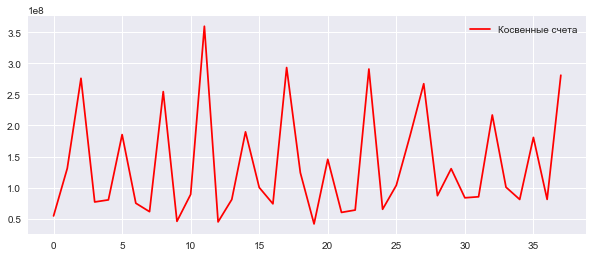

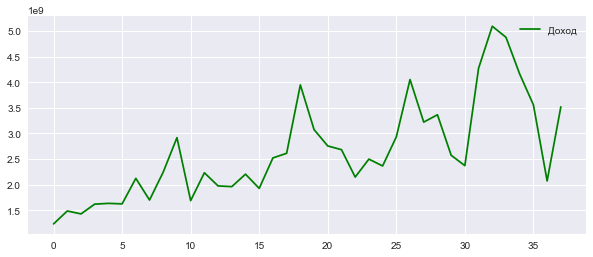

In [48]:
#plt.subplot(211)
plt.figure(figsize=(10,4))
plt.plot(xsum, 'r', label='Косвенные счета')
plt.legend()
plt.show()
#plt.subplot(212)
plt.figure(figsize=(10,4))
plt.plot(y, 'g', label='Доход')
plt.legend()
plt.show()

### 2.3 Prepare date for training

In [51]:
def resize_x_data(X, y, history=3):
    #history is 3 months by default
    N_MONTHS, N_ACCNTS,  = X.shape
    new_size = (N_MONTHS - history, history * N_ACCNTS)
    X_new = np.zeros(new_size)
    
    for i in range(new_size[0]):
        for j in reversed(range(1, history+1)):
            if j==history:
                a = X[i,:]
            else:
                a = np.concatenate((a,X[i + history - j]))
        X_new[i,:] = a

    return X_new

def resize_y_data(y, history=3):
    return y[history:]

In [52]:
X_new = resize_x_data(X, y)

In [65]:
X_new.shape

(35, 15)

In [66]:
y_new = resize_y_data(y)

In [67]:
y_new.shape

(35,)

## 3. Training

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,TimeSeriesSplit
from sklearn.linear_model import Lasso, LassoCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [83]:
def preprocess_data(X,y, history, test_size=0.2):
    #resize our data
    assert history > 0
    X_new = resize_x_data(X,y, history)
    y_new = resize_y_data(y, history)
    #split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=test_size, shuffle=False)
    #scale them
    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)
    Y_MEAN = y_train.mean()
    Y_STD = y_train.std()
    y_train_ss = (y_train - Y_MEAN)/Y_STD
    y_test_ss = (y_test - Y_MEAN)/Y_STD
    
    return X_train_ss, X_test_ss, y_train_ss, y_test_ss, ss, Y_MEAN, Y_STD

#### FIX test size:

In [84]:
test_size = 0.2

In [85]:
X_train, X_test, y_train, y_test, ss, Y_MEAN, Y_STD = preprocess_data(X, y, history=3, test_size=test_size)

### Time Series CV

In [97]:
rf_model = RandomForestRegressor(n_estimators=200, n_jobs=-1)

parameters_rf = {
    'max_depth': [2,3,5],
    'min_samples_split': [2,3,4]
}

gs_clf = GridSearchCV(rf_model,parameters_rf, scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=4), n_jobs = -1, verbose=5)

In [104]:
svr_model = SVR()
parameters_svr = {
    'C': np.logspace(-4,4,9),
    'kernel': ['rbf'],
    'gamma': np.logspace(-4,4,9),
    'epsilon': [1e-1]
}

gs_clf = GridSearchCV(svr_model, parameters_svr, scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=4), n_jobs=-1, verbose=5)

In [105]:
gs_clf.fit(X_train, y_train)

Fitting 4 folds for each of 81 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:    4.1s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=4),
       error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01,   1.00000e+02,   1.00000e+03,
         1.00000e+04]), 'kernel': ['rbf'], 'gamma': array([  1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01,   1.00000e+02,   1.00000e+03,
         1.00000e+04]), 'epsilon': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=5)

In [107]:
clf = gs_clf.best_estimator_
gs_clf.best_params_

{'C': 10.0, 'epsilon': 0.1, 'gamma': 100.0, 'kernel': 'rbf'}

In [108]:
y_pred = clf.predict(X_test)

In [109]:
print('Training error:\t', -1*gs_clf.best_score_)
print('Test error:\t', mean_squared_error(y_test, y_pred))

Training error:	 1.4364089779
Test error:	 7.34970190524


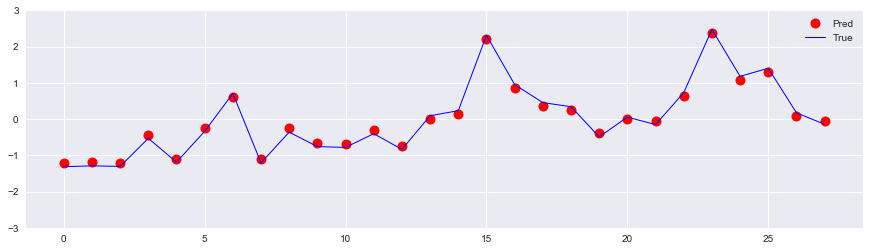

In [110]:
plt.figure(figsize=(15,4))
plt.plot(clf.predict(X_train), 'ro', ms=10)
plt.plot(y_train, 'b-', lw=1)
plt.legend(['Pred','True'], loc='best')
plt.ylim((-3,3))
plt.show()

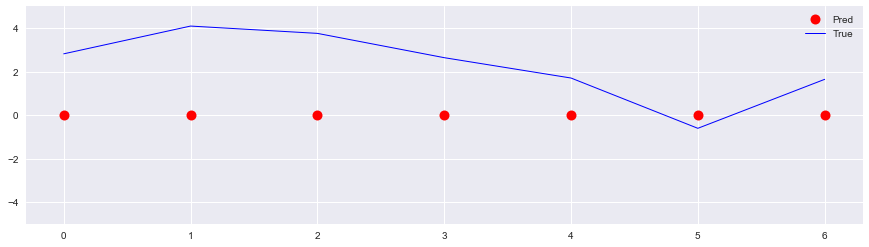

In [112]:
plt.figure(figsize=(15,4))
plt.plot(y_pred, 'ro', ms=10)
plt.plot(y_test, 'b-', lw=1)
plt.legend(['Pred','True'], loc='best')
plt.ylim((-5,5))
plt.show()

## 4. Tuning `history` parameter

In [109]:
def tune_history_parameter(X, y, histories, model, parameters, test_size=0.2):
    train_errors = []
    test_errors = []
    min_error = 1e+9
    
    for i in enumerate(histories):
        X_train, X_test, y_train, y_test, ss, Y_MEAN, Y_STD = preprocess_data(X, y, histories[i[0]], test_size=test_size)
        gs_clf = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=4, n_jobs=-1, verbose=False)
        gs_clf.fit(X_train, y_train)
        clf = gs_clf.best_estimator_
        train_errors.append(-1*gs_clf.best_score_)
        y_pred = clf.predict(X_test)
        error = mean_squared_error(y_test, y_pred)
        test_errors.append(error)
        
        if i[0]==0:
            print('Number of steps: ', len(histories))
            best_clf = clf
            best_params = gs_clf.best_params_
        if (error <= min_error):
            min_error = error
            idx_min = i[0]
            best_clf = clf
            best_params = gs_clf.best_params_
            
        print(str(i[0]+1)+'-th step is done!')
        print('Error: \t', error)
        
    return min_error, histories[idx_min], best_clf, best_params

In [110]:
svr_model = SVR()

parameters_svr = {
    'C': np.logspace(-10,5,16),
    'kernel': ['rbf'],
    'gamma': np.logspace(-12, 5,18),
    'epsilon': [0.1, 0.01, 1, 50, 100]
}

histories = np.arange(1,6)

min_error, best_history, best_clf, best_params = tune_history_parameter(X,y, histories, svr_model, parameters_svr, test_size=test_size)

Number of steps:  5
1-th step is done!
Error: 	 3.02483747704
2-th step is done!
Error: 	 2.32447520103
3-th step is done!
Error: 	 3.13335631057
4-th step is done!
Error: 	 3.187431481
5-th step is done!
Error: 	 3.28675481017


In [122]:
X_train, X_test, y_train, y_test, ss, Y_MEAN, Y_STD = preprocess_data(X, y, best_history, test_size=test_size)

In [123]:
best_params

{'C': 1e-10, 'epsilon': 100, 'gamma': 9.9999999999999998e-13, 'kernel': 'rbf'}

In [124]:
clf = SVR(C=best_params['C']*1e13, gamma=best_params['gamma']*3e9, kernel=best_params['kernel'])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_pred)
print('Training error:\t', train_error)
print('Test error:\t', test_error)

Training error:	 0.280920022404
Test error:	 0.180109904451


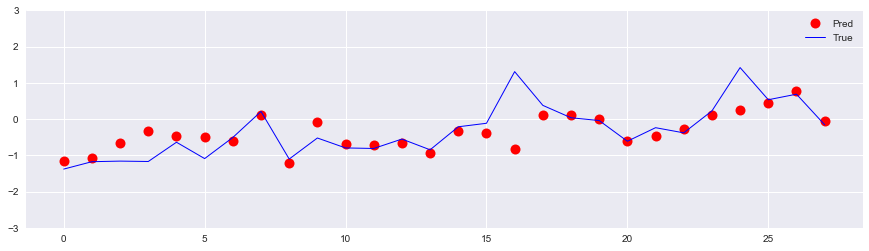

In [125]:
plt.figure(figsize=(15,4))
plt.plot(clf.predict(X_train), 'ro', ms=10)
plt.plot(y_train, 'b-', lw=1)
plt.legend(['Pred','True'], loc='best')

plt.ylim((-3,3))
plt.show()

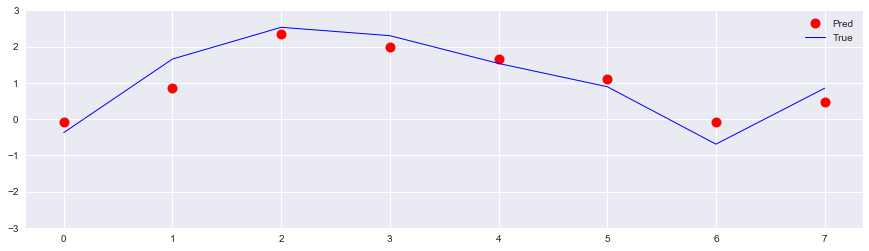

In [126]:
plt.figure(figsize=(15,4))
plt.plot(y_pred, 'ro', ms=10)
plt.plot(y_test, 'b-', lw=1)
plt.legend(['Pred','True'], loc='best')

plt.ylim((-3,3))
plt.show()

## 5. Step-by-step month prediction

In [140]:
def predict_step_by_step(clf, X_train, X_test, y_train, y_test):
    y_pred = []
    X_test_copy = X_test.copy()
    
    N_MONTHS = X_test.shape[0]
    for i in range(N_MONTHS-1):
        x = X_test[i, :].copy()
        #predict on the next month
        y = clf.predict([x])
        y_pred.append(y)
        #change train and test data
        X_train = np.vstack((X_train, x))
        y_train = np.concatenate((y_train,np.array(y)))

        #retrain our model
        clf.fit(X_train, y_train)
    #predict on the last month    
    y = clf.predict([X_test[-1,:]])
    y_pred.append(y)
        
    y_pred = np.array(y_pred)
    return y_pred

In [141]:
y_pred_sbs = predict_step_by_step(clf, X_train, X_test, y_train, y_test)
train_error = mean_squared_error(y_train, y_train_pred)
test_sbs_error = mean_squared_error(y_test, y_pred_sbs)
test_error = mean_squared_error(y_test, y_pred)
print('Training error:\t\t\t', train_error)
print('Test error:\t\t\t', test_error)
print('Test step-by-step error:\t', test_sbs_error)

Training error:			 0.00944474527874
Test error:			 3.31127200338
Test step-by-step error:	 3.31127200338


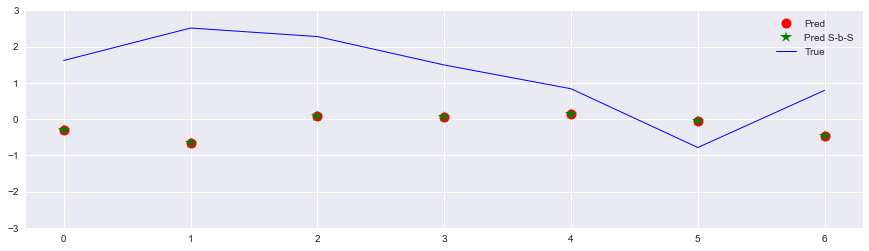

In [142]:
plt.figure(figsize=(15,4))
plt.plot(y_pred, 'ro', ms=10)
plt.plot(y_pred_sbs, 'g*', ms=12)
plt.plot(y_test, 'b-', lw=1)
plt.legend(['Pred','Pred S-b-S','True'], loc='best')

plt.ylim((-3,3))
plt.show()

#### Shift prediction on 2 months:

In [276]:
X_train_ = np.vstack((X_train[3:,:], X_test[:3,:]))
y_train_ = np.concatenate((y_train[3:], y_test[:3]))

In [277]:
clf = SVR(C=best_params['C']*1e13, gamma=best_params['gamma']*3e9, kernel=best_params['kernel'])
clf.fit(X_train_, y_train_)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.0030000000000000001, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [278]:
y_pred_ = clf.predict(X_test[3:,:])

In [279]:
y_test_ = y_test[3:]

In [280]:
mean_squared_error(y_test_,y_pred_)

0.24927680796134344

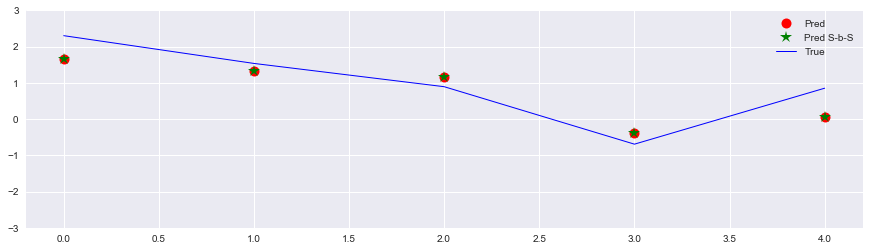

In [282]:
plt.figure(figsize=(15,4))
plt.plot(y_pred_, 'ro', ms=10)
plt.plot(predict_step_by_step(clf,X_train_,X_test[3:,:], y_train_,y_test[3:]), 'g*', ms=12)
plt.plot(y_test_, 'b-', lw=1)
plt.legend(['Pred','Pred S-b-S','True'], loc='best')

plt.ylim((-3,3))
plt.show()